# Bottle Cap Detection - Data Exploration
**Author:** Wikan Priambudi
**Goal:** Develop a lightweight detection model (<10ms inference) for Raspberry Pi 5.

## Import Libraries

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random

## Show 15 Images

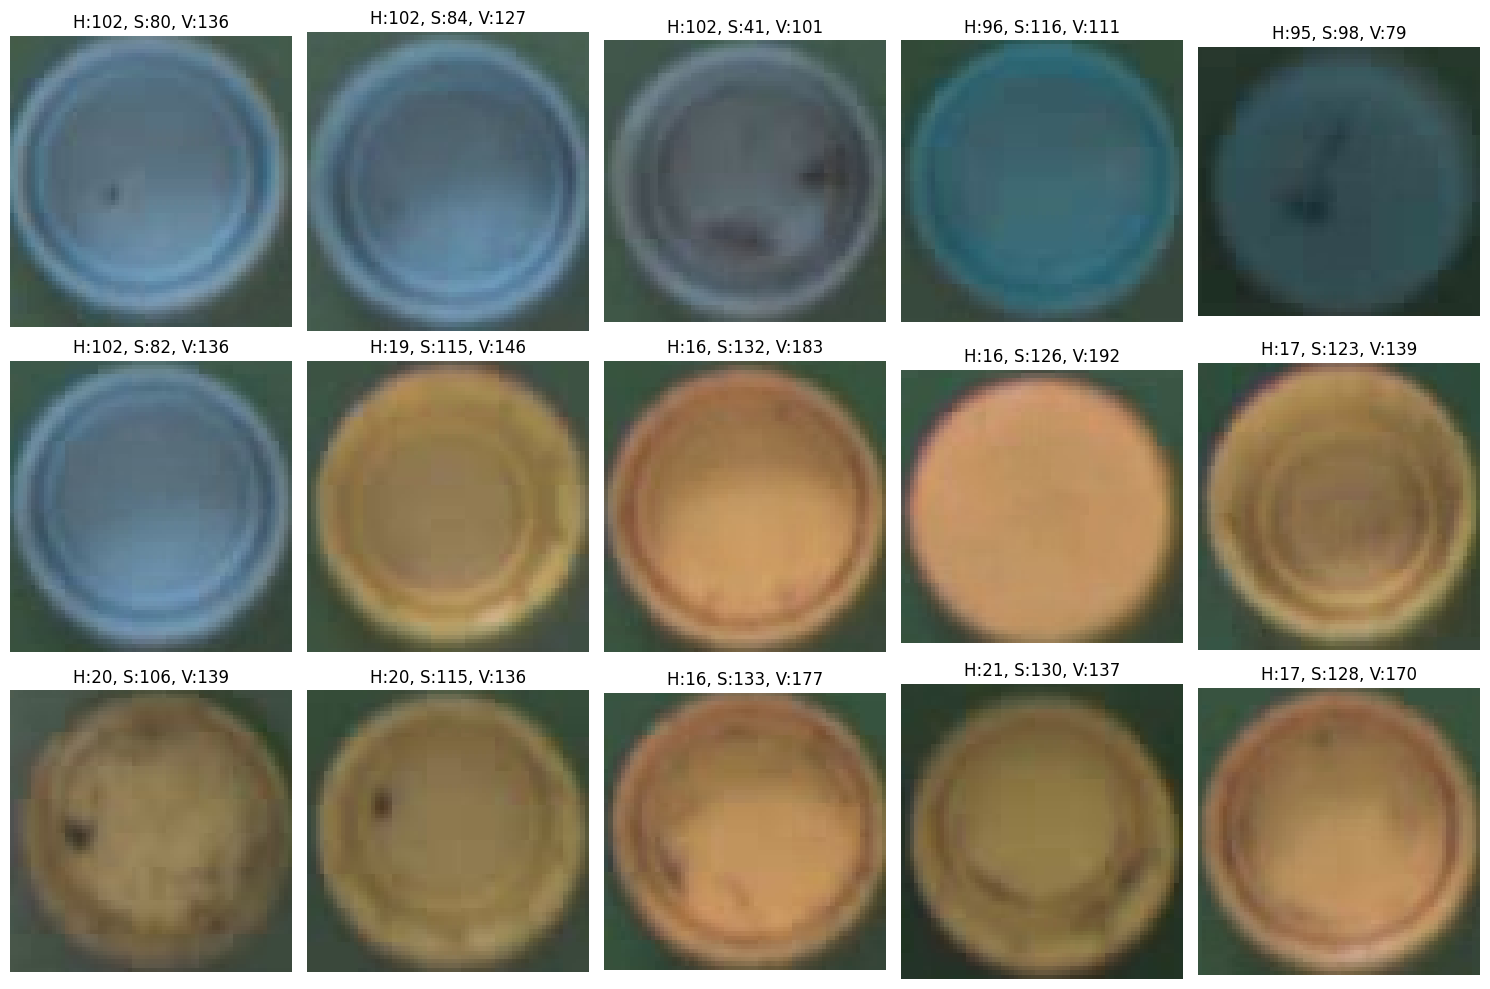

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Ambil beberapa sampel gambar dari folder train
image_files = glob.glob("../datasets/bottle_cap/train/images/*.jpg")[:3] # Ambil 3 gambar saja dulu

def get_hsv_stats(img_path, label_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, w, _ = img.shape
    
    crops = []
    stats = []
    
    if not os.path.exists(label_path): return [], []
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        # Koordinat YOLO
        x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert ke pixel
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Pastikan koordinat valid
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        # Ambil crop (potongan gambar tutup botol)
        crop_rgb = img_rgb[y1:y2, x1:x2]
        crop_hsv = img_hsv[y1:y2, x1:x2]
        
        if crop_rgb.size == 0: continue
            
        # Ambil bagian tengah saja (50%) untuk hindari background
        cy, cx = crop_hsv.shape[:2]
        center_hsv = crop_hsv[int(cy*0.25):int(cy*0.75), int(cx*0.25):int(cx*0.75)]
        
        # Hitung rata-rata H, S, V
        mean_h = np.mean(center_hsv[:,:,0]) # Hue (0-179 di OpenCV)
        mean_s = np.mean(center_hsv[:,:,1]) # Saturation (0-255)
        mean_v = np.mean(center_hsv[:,:,2]) # Value (0-255)
        
        crops.append(crop_rgb)
        stats.append((mean_h, mean_s, mean_v))
        
    return crops, stats

# Visualisasi
plt.figure(figsize=(15, 10))
k = 1
for img_file in image_files:
    lbl_file = img_file.replace('images', 'labels').replace('.jpg', '.txt')
    crops, stats = get_hsv_stats(img_file, lbl_file)
    
    for crop, stat in zip(crops, stats):
        if k > 15: break # Jangan kebanyakan plot
        plt.subplot(3, 5, k)
        plt.imshow(crop)
        plt.title(f"H:{stat[0]:.0f}, S:{stat[1]:.0f}, V:{stat[2]:.0f}")
        plt.axis('off')
        k += 1

plt.tight_layout()
plt.show()

## HSV Profile

Menganalisis 12 gambar... Mohon tunggu.


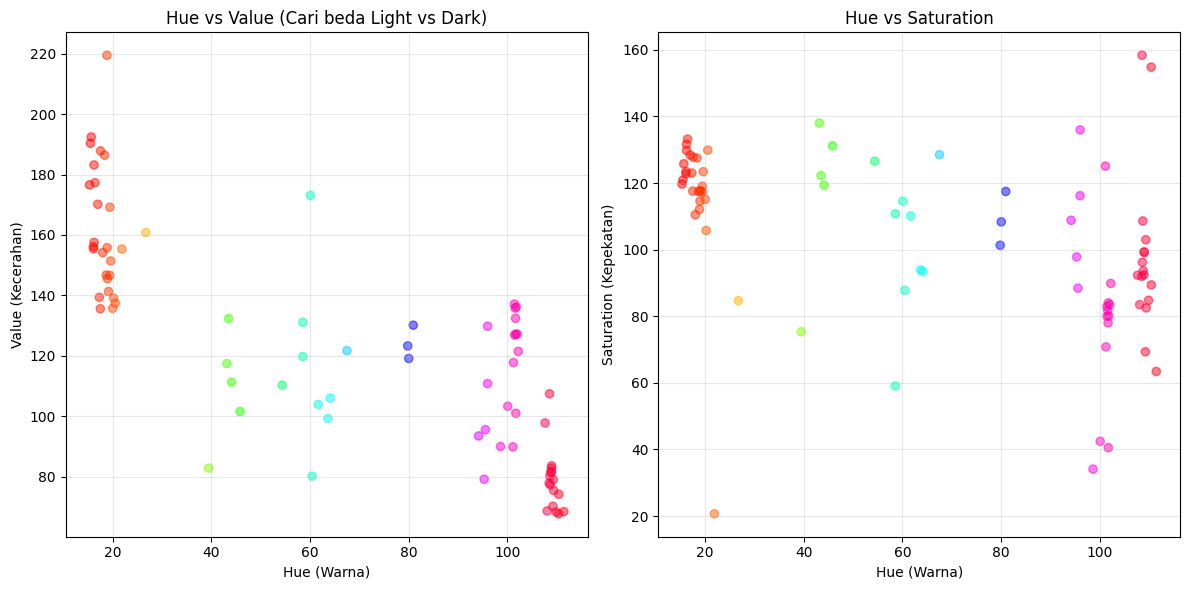

Total Tutup Botol terdeteksi: 79


In [11]:
# Ambil SEMUA gambar di folder train dan valid
train_images = glob.glob("../datasets/bottle_cap/train/images/*.jpg")
val_images = glob.glob("../datasets/bottle_cap/valid/images/*.jpg")
all_images = train_images + val_images

h_values = []
s_values = []
v_values = []

print(f"Menganalisis {len(all_images)} gambar... Mohon tunggu.")

for img_path in all_images:
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    if not os.path.exists(label_path): continue
    
    img = cv2.imread(img_path)
    if img is None: continue
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_img, w_img, _ = img.shape
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert ke pixel
        x1 = int((x_c - bw/2) * w_img)
        y1 = int((y_c - bh/2) * h_img)
        x2 = int((x_c + bw/2) * w_img)
        y2 = int((y_c + bh/2) * h_img)
        
        # Crop dan ambil tengahnya
        crop_hsv = img_hsv[y1:y2, x1:x2]
        if crop_hsv.size == 0: continue
            
        # Ambil area tengah 50% untuk akurasi warna
        cy, cx = crop_hsv.shape[:2]
        center = crop_hsv[int(cy*0.25):int(cy*0.75), int(cx*0.25):int(cx*0.75)]
        
        if center.size == 0: continue # Skip jika crop terlalu kecil

        h_val = np.mean(center[:,:,0])
        s_val = np.mean(center[:,:,1])
        v_val = np.mean(center[:,:,2])
        
        h_values.append(h_val)
        s_values.append(s_val)
        v_values.append(v_val)

# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Hue vs Value (Biasanya untuk membedakan Light vs Dark)
plt.subplot(1, 2, 1)
plt.scatter(h_values, v_values, alpha=0.5, c=h_values, cmap='hsv')
plt.xlabel('Hue (Warna)')
plt.ylabel('Value (Kecerahan)')
plt.title('Hue vs Value (Cari beda Light vs Dark)')
plt.grid(True, alpha=0.3)

# Plot 2: Hue vs Saturation (Cari beda Warna Lain)
plt.subplot(1, 2, 2)
plt.scatter(h_values, s_values, alpha=0.5, c=h_values, cmap='hsv')
plt.xlabel('Hue (Warna)')
plt.ylabel('Saturation (Kepekatan)')
plt.title('Hue vs Saturation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total Tutup Botol terdeteksi: {len(h_values)}")

### Labelling Result

In [12]:
# Fungsi Helper untuk menampilkan gambar spesifik per kelas
def show_class_examples(target_class_id, class_name, bbox_color, folder):
    # Cari semua file label di folder train
    if folder == 'train':
        label_files = glob.glob("../datasets/bottle_cap/train/labels/*.txt")
    else:
        label_files = glob.glob("../datasets/bottle_cap/valid/labels/*.txt")

    found_images = []
    
    # Acak biar gak itu-itu aja yang tampil
    random.seed(42)
    random.shuffle(label_files)
    
    for lbl_path in label_files:
        if len(found_images) >= 6: break # Cukup tampilkan 6 gambar
        
        # Cek apakah di file ini ada class yang dicari
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            
        bboxes = []
        has_target = False
        
        for line in lines:
            parts = line.strip().split()
            cls_id = int(parts[0])
            
            # Hanya ambil kotak yang sesuai kategori target
            if cls_id == target_class_id:
                bboxes.append(list(map(float, parts[1:])))
                has_target = True
                
        if has_target:
            # Load gambar
            img_path = lbl_path.replace('labels', 'images').replace('.txt', '.jpg')
            if not os.path.exists(img_path): continue
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape
            
            # Gambar kotak
            for box in bboxes:
                xc, yc, bw, bh = box
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                
                cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, 3)
                cv2.putText(img, class_name, (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, bbox_color, 2)
            
            found_images.append(img)
    
    # Plotting
    if not found_images:
        print(f"Tidak ditemukan sampel untuk kelas: {class_name}")
        return

    plt.figure(figsize=(15, 10))
    for i, img in enumerate(found_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{class_name} (Samples)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Menampilkan sampel LIGHT BLUE (Class 0)...


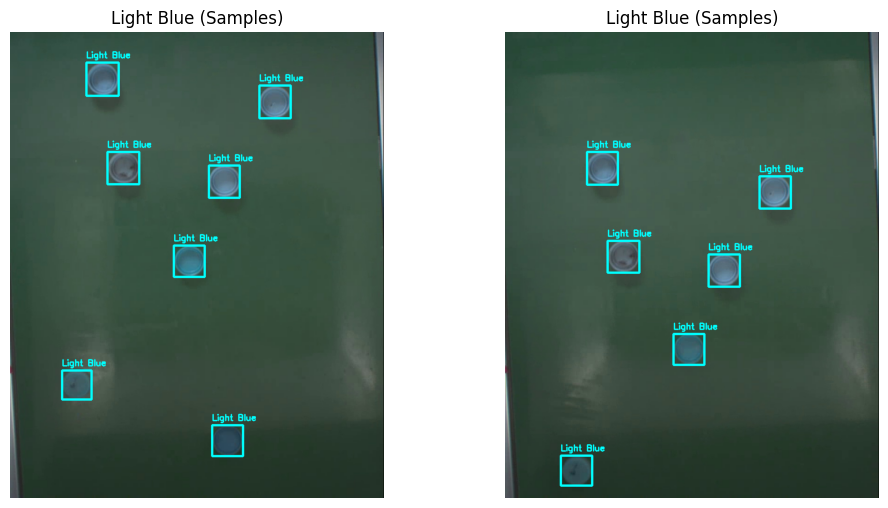

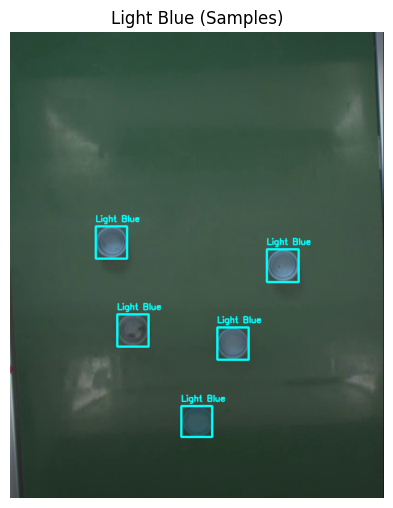

In [13]:
# --- EKSEKUSI LIGHT BLUE ---
print("Menampilkan sampel LIGHT BLUE (Class 0)...")
# Warna Kotak: Cyan (0, 255, 255)
show_class_examples(0, "Light Blue", (0, 255, 255), 'train')
show_class_examples(0, "Light Blue", (0, 255, 255), 'valid')

Menampilkan sampel DARK BLUE (Class 1)...


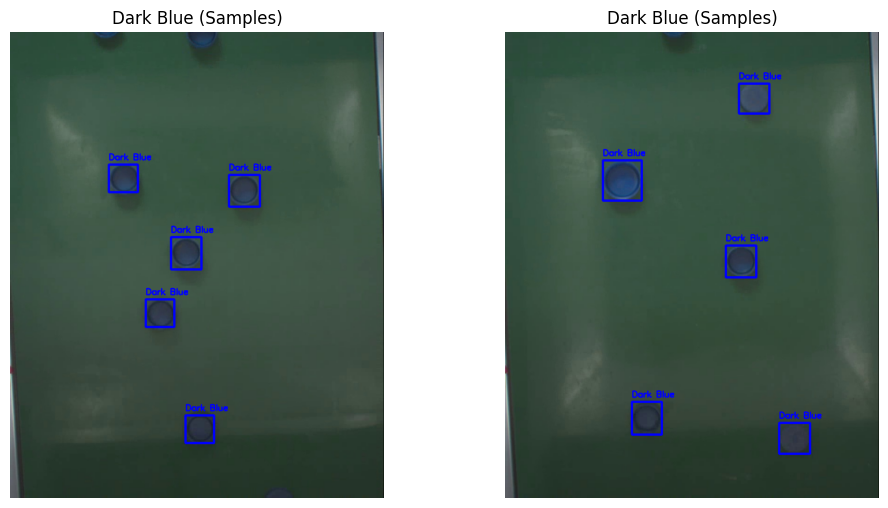

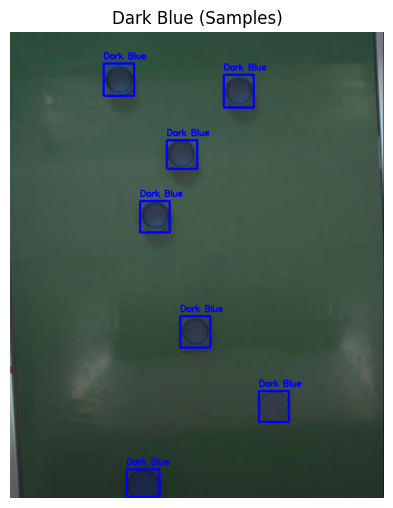

In [14]:
print("Menampilkan sampel DARK BLUE (Class 1)...")
show_class_examples(1, "Dark Blue", (0, 0, 255), 'train')
show_class_examples(1, "Dark Blue", (0, 0, 255), 'valid')

Menampilkan sampel OTHER (Class 2)...


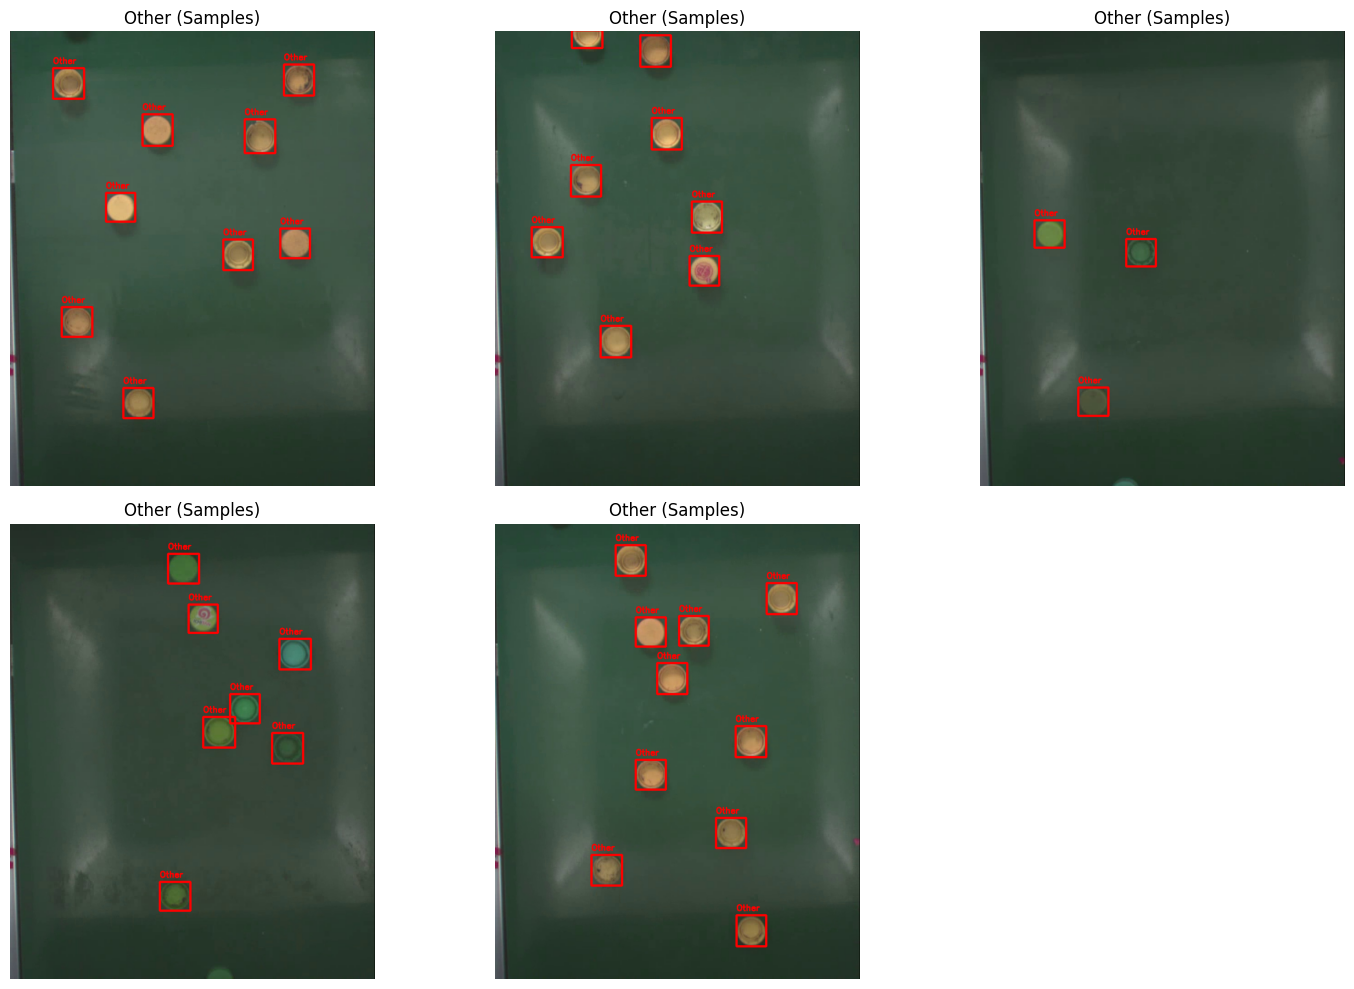

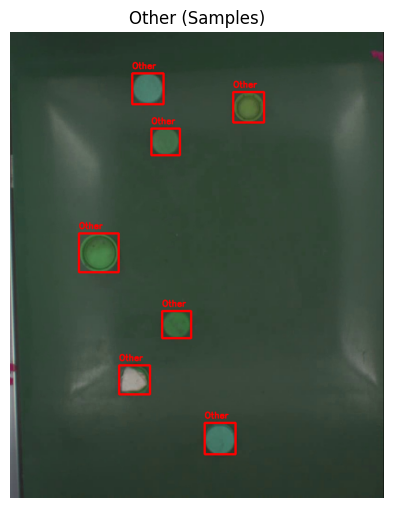

In [15]:
print("Menampilkan sampel OTHER (Class 2)...")
show_class_examples(2, "Other", (255, 0, 0), 'train')
show_class_examples(2, "Other", (255, 0, 0), 'valid')